# House Pricing Linear Regression using the California Housing Prices Dataset

## Objective:
- Build a model of housing prices in the state
- Predict the median housing price in any district given all other metrics

## 1. Frame the Problem
- Business objective: build a predictive model that will be fed into anothe ML System in order to determine if it is worthwile investing in a given area. This directly affects revenues.
- What is the current solution? --> manual estimations done by experts, costly and time consuming. Estimations are sometimes off by 30%

### System design
- Supervised learning as we have labeled examples (output expected is given in the training data)
- Regression task since a value needs to be predicted 
- Multiple Regression (multiple features will be used to make a prediction)
- Univariate Regression since we only want to predict one value, the price. 
- Batch learning: no continuous flow of data coming into the system, data is small enough to fit in memory. 

### Performance measure
- RMSE: error the system typically makes in its predictions, higher weight is given to large erros. 
- MAE: if we find to have many outlier districts (average absolute deviation)

Both RMSE and MAE are a way to measure the distance between 2 vectors, the vector of predictions and the vector of target values. RMSE is more sensitive to outliers. 

# Load data and first analysis


This example comes from the book Hands-On Machine Learning from A. Geron (3rd Edition)

<span style="background-color:yellow; color:black">! Running the entire notebook can take up several minutes as various GridSearches/RandomizedSearches are performed. </span>

In [103]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [104]:
#load data

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
display(housing.head())
display(housing.info())
display(housing.describe())
#missing values
missing = housing.isnull().sum()
missing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [4]:
# categorical feature, modalities
housing["ocean_proximity"].value_counts()
# histogram

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

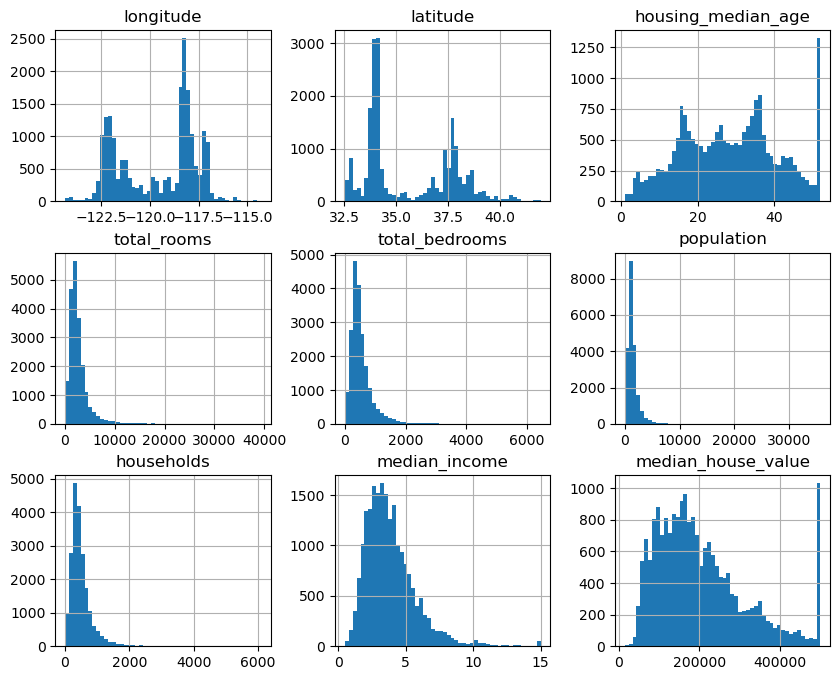

In [5]:
# histogram of numerical attributes
housing.hist(bins=50, figsize=(10, 8))
plt.show()
# save_fig("attribute_histogram_plots")

### Important!
- median income scaled (x 10000) and capped
- housing median age capped
- housing median value capped at 500000

- scaling differs, to be treated after train/test split
- skewed right, not normally distributed --> we could think of converting to log or sqrt 

### Create a test set and put apart (data snooping bias) 

In [6]:
#test set function
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#split
train_set, test_set = split_train_test(housing, 0.2)
#check
len(train_set), len(test_set)



(16512, 4128)

! THIS SOLUTION WILL BREAK IN THE FUTURE WHEN NEW DATA IS ADDED. A NEW TEST SET WILL BE GENERATED AND EVENTUALLY THE ML ALGO WILL GET TO SEE THE ENTIRE DATASET. 

    - Alternative 1: `np.random.sees(42) before np.random.permutation` --> this will also break after adding new data, but test set will remain constant
    
    - Alternative 2: Save test set separately
    
    - Alternative 3: Use each instance's identifier to decide whether or not it should go in the test set. Code in page 57.  We will not do this. 

    

### Train test split with sklearn


In [7]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#### Missing values for 'total_bedrooms' --> will be handled later


In [8]:
#missing values
train_set.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        163
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
test_set.isnull().sum()

longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms        44
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        0
dtype: int64

#### Median Income analysis/ discretization (create classes)

- This is an important feature
- Quantitive  variable --> we see  most values are clustered between $15k-$60k (remembered it is scaled down and capped))
- We will use the pandas  `pd.cut()` function and create 5 classes. 
- It is important not to have to many strata and that each stratum is large enough
- We will split income median into 5 categories and name the new column 'income_cat'
- Then we will perform a stratified sample split based on this


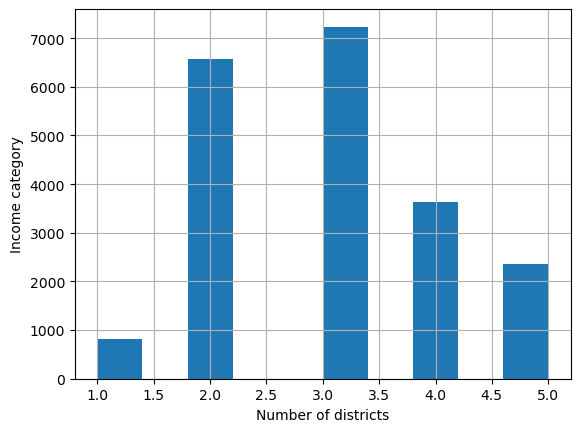

In [10]:
#  5 bins using pd.cut()

housing["income_cat"] = pd.cut(housing["median_income"],
    bins=[0., 1.5, 3., 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5])

#plot
housing["income_cat"].hist()
plt.xlabel('Number of districts')
plt.ylabel('Income category')
plt.show()

#### Review dataset, do we have a representative set? Sampling bias

### STRATIFIED SAMPLING 
The population is divided into homogenous groups called strata and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. 

- Here:  before stratified sampling we observe differente income_cat proportions in the test set --> this will be important in the future. For now we will drop again the income_cat column (pg. 60)

In [11]:
# stratified sampling based on income category using train_test_split
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42,
    stratify=housing["income_cat"])

In [12]:
# review proportion in both sets
display(strat_train_set["income_cat"].value_counts() / len(strat_train_set))
display(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [13]:
# proportion in full dataset
display(housing["income_cat"].value_counts() / len(housing))

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [14]:
# drop income cat in strat_train and strat_test
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Explore and visualize the data

- test set is put apart, it will not be looked at
- if train set is too large, put a part of it away to have easier manipulatino of the data, in our case this won't be necessary. 
- make a copy of the original train_set to be able to revert aftewards

In [15]:
print('Shape Strat_train_set:  ', strat_train_set.shape)

housing = strat_train_set.copy()
housing.shape

Shape Strat_train_set:   (16512, 10)


(16512, 10)

#### Observing Geographical Data

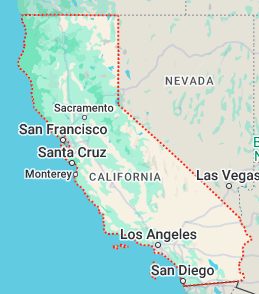

We clearly see the higher density areas around San Francisco,  Los Angeles and San Diego area.


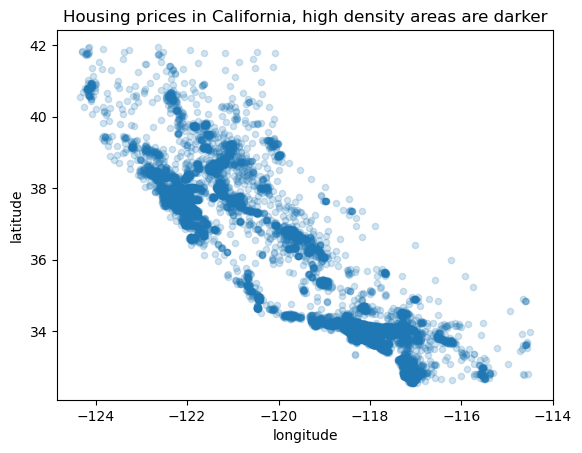

In [16]:
#scatterplot with longitudes and latitudes
print( 'We clearly see the higher density areas around San Francisco,  Los Angeles and San Diego area.')
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
plt.title("Housing prices in California, high density areas are darker")
plt.show()


#alpha= 0.02 to be able to distinguish high density areas from low density areas
# high density meaning more data points

We will enhance the scatterplot with the house prices (red for most expensive), in addition larger circles represent larger populations.


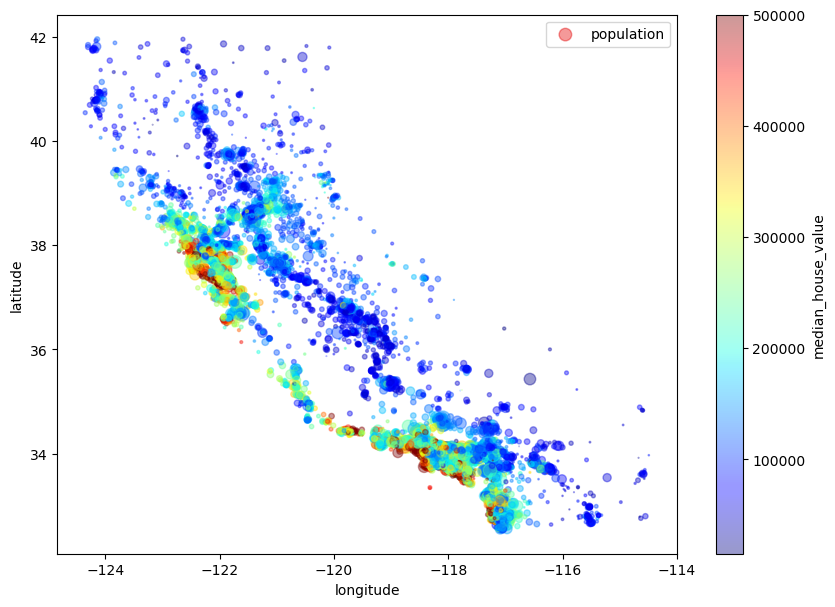

In [17]:
# inlcude median house value and population in sctterplot
print('We will enhance the scatterplot with the house prices (red for most expensive), in addition larger circles represent larger populations.')

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10, 7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, 
    legend=True, sharex=False)
plt.legend();

- This image clearly shows us a relationship between median_house_value and location. 
- Closer to the ocean is where we find the higher prices (in reddish), except in the northern coast where this does not seem to apply. 

- Further more we also see a relationship to population size (portrayed by larger bubbles) and lower house values. 

#### Correlation coefficient (only for linear relationships) --> Pearson's r


In [18]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


In [19]:
# Correlations to median_house (Pearson's r)
numeric_columns = housing.select_dtypes(include=['number']).columns
corr_matrix = housing[numeric_columns].corr()
display(corr_matrix["median_house_value"].sort_values(ascending=False))

print( 'Strong correlation between the median house value and the median income')
print('Slight negative correlation between the median house value and the location --> lower prices in the north')

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Strong correlation between the median house value and the median income
Slight negative correlation between the median house value and the location --> lower prices in the north


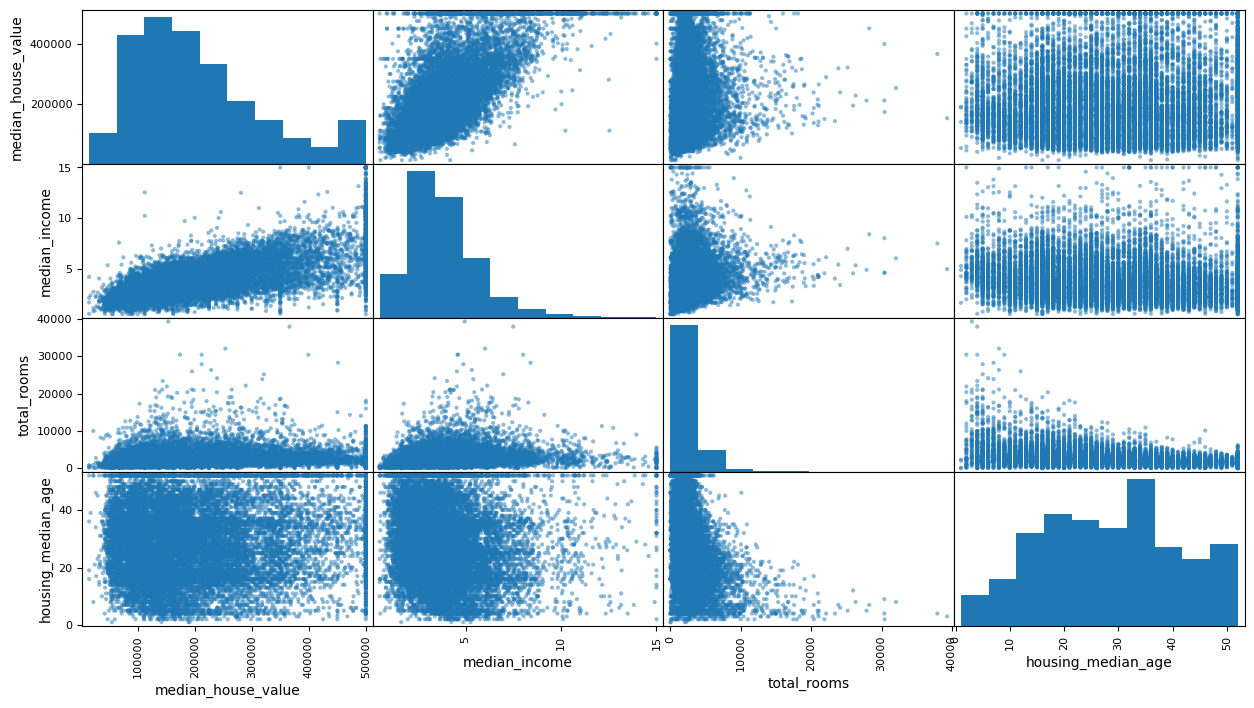

As calculated, the most correlated feature, median_income, is the most interesting
Clear upward trend, points are not too scattered
Horizontal line at the top reveals the price cap at $500k
There seem to be further horizontal lines at around $350k, $450k, maybe also aroun $280k
We might remove these districts from the data to prevent the algorithms from learning these patterns


In [20]:
#scatter matrix to display correlations
#focus on the most correlated attributes
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(15, 8))
plt.show()

print('As calculated, the most correlated feature, median_income, is the most interesting')
print('Clear upward trend, points are not too scattered')
print('Horizontal line at the top reveals the price cap at $500k')
print('There seem to be further horizontal lines at around $350k, $450k, maybe also aroun $280k')
print('We might remove these districts from the data to prevent the algorithms from learning these patterns')

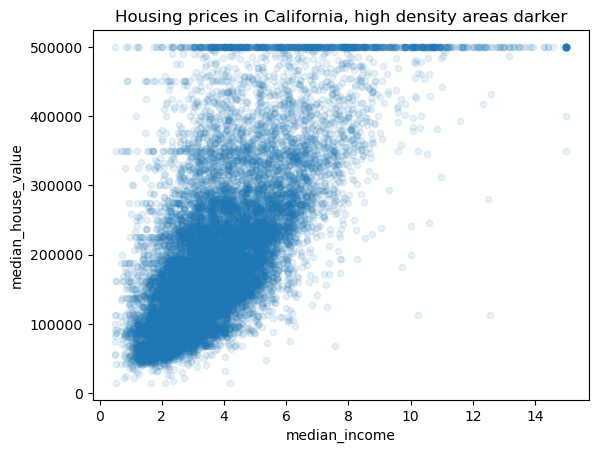

In [21]:
# zoomin on median_income
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.title("Housing prices in California, high density areas darker")
plt.show()

#### Feature Engineering
- Experimenting with some attributes

- total_number_rooms to households
- total_ umber_bedrooms to rooms
- population per household


In [22]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_household'] = housing['population'] / housing['households']
# check correlation
corr_matrix = housing[numeric_columns].corr()
display(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

- We observe stronger corrs of the bedrooms_ratio to the median_house_value as the total_rooms or total_bedrooms. 
- Lower bedrooms_ratio tend to be more costly .
 


#### Prepare data for ML Algos
- Use functions for reusability (when new data arrives)
- Easier transformations to test different combinations

In [23]:
# make a copy and split the data in predictors X and target y
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [24]:
# impute missing data (replace missing values with median) --> total_bedrooms has missing values
# only one feature has missing values, but maybe new future data has also missing values so it is safer to apply imputer on all numerical features
#create instance
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

#get only numerical attributes
housing_num = housing.select_dtypes(include=[np.number])
# fit to training set only
imputer.fit(housing_num)
#show calculated median
print(imputer.statistics_)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


The simple Imputer stores the median value of each feature and makes it possible to impute missing values not only on the train set but also on the validation set and any new value added to the model. (strategy can also bea 'mean', 'most_frequent' or  'constant' with fill_value=... )

In [25]:
# transform the train  data using the trained imputer
X = imputer.transform(housing_num)

##### Transform to dataframe

Scikit transformers output Numpy arrays (or sparse matrices) --> X has neither columns nor index. We must now dataframe our output

In [26]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
    index=housing.index)
#check if no more missing values
display(housing_tr.isnull().sum())
# check if the imputer worked  
housing_tr.describe()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,537.881298,1425.513929,499.990189,3.870428
std,2.000624,2.133294,12.585738,2185.287466,421.831667,1094.795467,382.865787,1.891936
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.000000,297.000000,787.000000,279.000000,2.562500
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500
75%,-118.010000,37.720000,37.000000,3154.000000,642.000000,1726.000000,603.000000,4.750000
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100


### Categorical attributes

- Ocean Proximity


In [27]:
# modalities ocean_proximity
housing_cat=housing[['ocean_proximity']]
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64

##### Ordinal encoder vs. One-Hot Encoder

- ML Algos work with numbers, so we need to convert the categorical values to numbers
- ML Algos could assume that 2 ordinally encoded values are more similar than two distant values, this might not always be the case. 
- Insteas of using ordinal encoding we will stick to OHE and create 'dummy' atributes.  (OHE gives a sparse matrix, empty except 1  '1' per row. saves plenty of memory. , if your sset sparse=False you get directly a numpy array)

In [28]:
# convert to numerical values using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder() 
housing_cat_ohe = ohe.fit_transform(housing_cat[["ocean_proximity"]])
housing_cat_ohe.toarray()



array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [29]:
ohe=OneHotEncoder(sparse_output=False)
housing_cat_1hot = ohe.fit_transform(housing_cat[["ocean_proximity"]])
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [30]:
ohe.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [31]:
df_test=pd.DataFrame({'ocean_proximity':['INLAND', 'NEAR BAY']})
pd.get_dummies(df_test)


,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [32]:

ohe.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [33]:
df_test_unknown=pd.DataFrame({'ocean_proximity':['ISLAND', '<2H OCEAN']})
pd.get_dummies(df_test_unknown)
# transform unknown categories

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,False,True
1,True,False


In [34]:
# with ohe we get all columns, and new are added if unknown in the dataframe
ohe.handle_unknown = 'ignore'
ohe.transform(df_test_unknown)

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [35]:
ohe.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [36]:
ohe.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

### Feature Scaling

- clip=True --> set this hyperparameter to true if new data comes in and shouldn't be scaled otuside the range
- ***MinMaxScaler *** -> normalization to values between 0-1.--> feature_range hyperparameter lets you change to -1 to 1 -> neural networks work best with zero-mean inputs. 
- ***Standardization*** --> mean=0, STD=1, values are not restricted to a specific range. It is less affected by outliers pg. 76 example.

In [37]:
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
min_max_scaler=MinMaxScaler(feature_range=(-1,1))
# fit to training set only
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [38]:
#standardscaler
from sklearn.preprocessing import StandardScaler
std_scaler=StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)
# check

Multimodal distribution (>1 peaks). We can either trasnform it by bucketizing. 
Another approach is to add a feature for each of the modes representing the similarity  between the housing median age and that particular mode. --> RADIAL BASIS FUNCTION (rbf)


Gamma hyperparameter determines how qickly the similarity measure decays as x moves away from 35. 
Below the new feature as a funciton of the housing median age.
We see the new age similarity feature is very similar to the original feature, but it is more compact and has a single peak. 
It peaks at 35, and the similarity decays quickly as we move away from 35. 
The new feature is a good candidate for a linear model, while the original feature is not. 
if this particular groupd is well correlated with lower prices, there is a good chance that this new feature will help. 


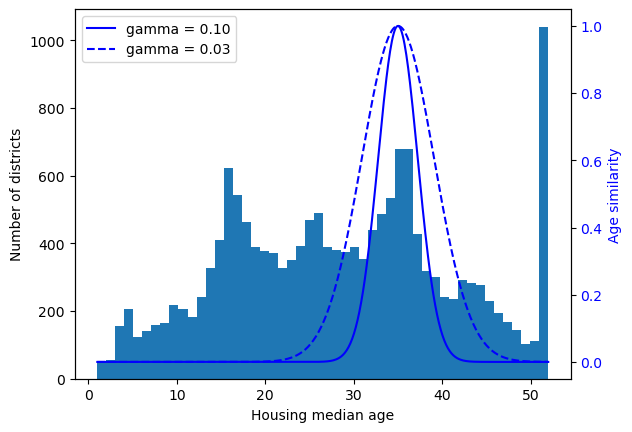

In [39]:
print('Multimodal distribution (>1 peaks). We can either trasnform it by bucketizing. ')
print('Another approach is to add a feature for each of the modes representing the similarity  between the housing median age and that particular mode. --> RADIAL BASIS FUNCTION (rbf)')
print('\n')
print('Gamma hyperparameter determines how qickly the similarity measure decays as x moves away from 35. ')
print('Below the new feature as a funciton of the housing median age.')
print('We see the new age similarity feature is very similar to the original feature, but it is more compact and has a single peak. ')
print('It peaks at 35, and the similarity decays quickly as we move away from 35. ')
print('The new feature is a good candidate for a linear model, while the original feature is not. ')
print('if this particular groupd is well correlated with lower prices, there is a good chance that this new feature will help. ')

from sklearn.metrics.pairwise import rbf_kernel
age_simil_35=rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

# extra code – this cell generates Figure 2–18 pg. 78

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

#### Review Target values
- do they have a heavy tail and need to be rescaled?
- replace with their log? (only if heave tail, positive, tail on the right!)
- if we use the log, after we have to compute the  exponential of the model's prediction
- for this we can use the onverse_transform() method from scikit
- target value is a pandas series (1 col) --> we need to convert to a dataframe because the standard scaler expects D inputs. 
- simple example in pg. 79, training only on median income feature, for simplicity

In [40]:
from sklearn.linear_model import LinearRegression
target_scaler=StandardScaler()
scaled_labels=target_scaler.fit_transform(housing_labels.to_frame())

model=LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data=housing[['median_income']].iloc[:5] # pretend new data

scaled_predictions=model.predict(some_new_data)
# inverse transform the predictions
predictions=target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

#### TransformedTargetRegressor
- an alternative and simpler way is to use the ´TransformedTargetRegressor´
- it automatically uses the transformer to scale the labels and train the regression model on the resulting scaled labels. then when we make the prediction, it will call the regression models ´predict()´ method and use the scaler's ínverse_transform()´method to produce the prediction

In [41]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(housing[['median_income']], housing_labels)
predictions= model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers
#### FunctionTransformer


##### Log transformer 

In [42]:
from sklearn.preprocessing import FunctionTransformer

log_transformer=FunctionTransformer(np.log, inverse_func=np.exp)

log_pop= log_transformer.transform(housing[['population']])
log_pop
#--> there is something wrong in the output. 


,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


#####  Gaussian rbf_transformer

In [43]:
rbf_transformer=FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))

age_simil_35=rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [44]:
# example how to add a feature that will measure the geographic similarity b/w each district and SanFrancisco
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

Example below: this code uses FunctionTransformer to create a reusable transformer that calculates the ratio of the first element to the second element of each row in a given NumPy array. It then applies this transformation to the example array [[1., 2.], [3., 4.]], resulting in an array containing the ratios [[0.5], [0.75]].

In [45]:
# combine features transformer example: compute ratio b/w input features 0 and 1

ratio_transformer = FunctionTransformer(lambda x: x[:, 0] / x[:, 1])
ratio_transformer.transform(np.array([[1, 2], [3, 4]]))


array([0.5 , 0.75])

### Writing a custom class so that transformer is trainable, learning some parameters in the fit() methid and using them later in the transform() method

Example: Customer transformer that acts as a standardscaler

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

Example: customer transformer that uses a KMeans clusterer in the fit() method to identify the main clusters int he training data and then uses rbf_kernel() in the transform() method to measure how similar each sample is to each cluster center.

In [47]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [48]:
# using the custom transformer
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

#this code creates a ClusterSimilarity transformer setting the number of clusters to 10, the gamma parameter to 1.0, and the random state to 42.
# then itcalls fit_transform() with the latitude and longittude of every district in the training set, weighting each district by its median house value. the transformer uses the kmeans to locate the clusters
#then measures the gaussian rbf similarity b/w each district and all 10 cluster centers
#the result is a matrix with one row per district and one column per cluster

# the values in the matrix are the similarities b/w each district and the cluster centers
# the higher the similarity, the closer the district is to the cluster center
# the result is a new feature that can be used in the model training

similarities

array([[7.90165632e-02, 4.29901164e-14, 6.03972145e-01, ...,
        1.98273138e-03, 6.66241631e-17, 1.40931619e-01],
       [5.82488504e-14, 9.90046143e-01, 1.62296800e-10, ...,
        2.99695991e-26, 6.32121447e-01, 1.49980122e-09],
       [4.44899714e-01, 1.43260203e-14, 2.98432127e-01, ...,
        1.01045486e-02, 2.87904572e-17, 2.88731307e-01],
       ...,
       [2.14229240e-25, 2.34767544e-02, 1.27755043e-20, ...,
        1.36785104e-41, 1.24070781e-01, 2.69295229e-19],
       [3.04522421e-14, 9.94603128e-01, 1.12895602e-10, ...,
        1.35896633e-26, 6.41870993e-01, 9.22745279e-10],
       [5.88813824e-02, 1.30531503e-13, 6.95132975e-01, ...,
        9.77188785e-04, 2.16738176e-16, 1.42368832e-01]])

 These are the 10 cluster centers found by kmeans. The districts are colored according to their geographic similarity to their closes cluster center. Most cluster are located in highly populated and expensive areas. 


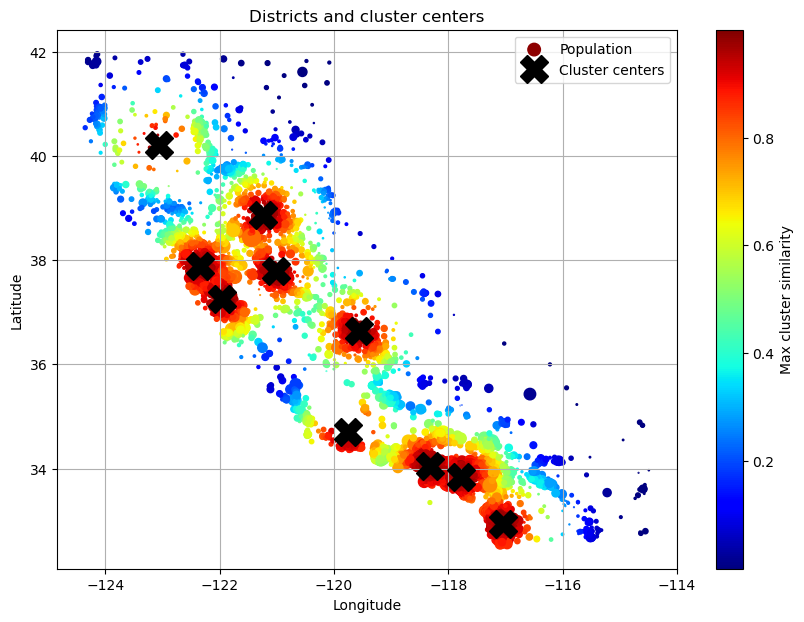

In [49]:
# Gaussian rbf similarity to the nearest cluster

print(' These are the 10 cluster centers found by kmeans. The districts are colored according to their geographic similarity to their closes cluster center. Most cluster are located in highly populated and expensive areas. ')
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.title("Districts and cluster centers")
plt.show()

### Transformer Pipelines

- transform in the right order --> sequences of transformations

In [50]:
#example: first impute and then scale input features (numerical)

from sklearn.pipeline import Pipeline

num_pipeline= Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

In [51]:
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [52]:
# creating a Pipeline without naming the transformers 
#make_pipeline
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
# check
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

- in the example the last estimator is a transformer so the pipeline als acts like a transformer. 
- if you call the pipelines transform() method it will sequentially apply all the. transformations to the data.
- if the last estimator were a predictor instead of a transformer, then the pipeline would have a predict() method rather than a transform() method. calling it would seq. apply all transformations to the data and pass the result to the predictors predict() method


In [53]:
housing_num.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
1286,-121.31,37.96,52.0,1829.0,301.0,694.0,319.0,3.3466
18078,-118.36,33.85,34.0,1086.0,197.0,509.0,158.0,6.1133
4396,-122.13,37.41,36.0,4787.0,900.0,2039.0,890.0,5.4063
18031,-118.44,34.31,22.0,3182.0,822.0,2661.0,746.0,2.7472
6753,-118.13,34.06,17.0,1714.0,572.0,1590.0,568.0,1.1875


In [54]:
# we call the pipeline for the example above
housing_num_prepared=num_pipeline.fit_transform(housing_num)
housing_num_prepared[:3].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17],
       [-1.2 ,  1.28,  0.35, -0.71, -0.76, -0.79, -0.78, -0.76]])

In [55]:
# use get_feature_names_out() method to recover a DataFrame
df_housing_num_prepared=pd.DataFrame(housing_num_prepared,
    columns=num_pipeline.get_feature_names_out(),
    index=housing.index)
df_housing_num_prepared.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
1286,-0.868193,1.088610,1.861119,-0.370856,-0.561571,-0.668194,-0.472739,-0.276883
18078,0.606392,-0.838047,0.430885,-0.710868,-0.808122,-0.837181,-0.893265,1.185526
4396,-1.278077,0.830784,0.589800,0.982782,0.858470,0.560383,1.018690,0.811824
18031,0.566403,-0.622412,-0.522604,0.248303,0.673556,1.128543,0.642568,-0.593710
6753,0.721359,-0.739605,-0.919891,-0.423482,0.080885,0.150248,0.177639,-1.418129


In [56]:
#pipeline supports indexing: here the second estimator is returned
num_pipeline[1]

StandardScaler()

### ColumnTransformer - for both categorical and numerical columns

In [57]:
from sklearn.compose import ColumnTransformer
#define list of  numerical and categorical columns
num_attribs=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
              'total_bedrooms', 'population', 'households', 'median_income']
cat_attribs=['ocean_proximity']

#make_pipeline
cat_pipeline=make_pipeline(SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

#construct columntransformer 
# --> requires 3-tuples with a unique name(no double underscores), a transformer (pipeline), 
# and list of names or indices of columns that the transformers should be applied to. 
preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])
# check
preprocessing


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity'])])

#### make_column_transformer 
- returns selector function to automatically select all features of a given type (like num or cat)
- also the funciton can make the names for you if you dont want to give the names


In [58]:
#example 
from sklearn.compose import make_column_selector, make_column_transformer
preprocessing=make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)
# check
preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1295bed20>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1295bddc0>)])

In [59]:
#### Apply to housing data
housing_prepared=preprocessing.fit_transform(housing)
housing_prepared[:3].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94,  0.  ,
         0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ],
       [-1.2 ,  1.28,  0.35, -0.71, -0.76, -0.79, -0.78, -0.76,  0.  ,
         1.  ,  0.  ,  0.  ,  0.  ]])

#### Pipeline for all transformations
- missing values in numerical features impute with median
- missing values in categorical features will be replaced by most_frequent
- OHE of categorical features
- ratios added (new features) : bedrooms_ratio, rooms_per_house, people_per_house
- cluster similarity features will be added (will likely be more usefule than latitude and longitude)
- long tailed features replaced with their log (most models prefer features with roughl uniform or gaussian distributions)
- all numerical features will be standardized (to have same scale)


In [60]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [61]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared[:3].round(2)

array([[ 1.85, -0.87, -0.33,  1.32,  0.64,  0.46,  1.31, -1.07,  0.  ,
         0.97,  0.  ,  0.  ,  0.  ,  0.08,  0.  ,  0.  ,  0.13,  0.57,
         0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  1.86],
       [-0.51,  0.02, -0.25, -0.25, -0.06, -0.71, -0.14,  1.19,  0.12,
         0.  ,  0.98,  0.03,  0.  ,  0.  ,  0.  ,  0.54,  0.  ,  0.  ,
         1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.91],
       [-0.2 , -0.04, -0.05, -0.93, -0.86, -0.94, -0.91, -0.76,  0.  ,
         0.75,  0.  ,  0.  ,  0.  ,  0.44,  0.  ,  0.  ,  0.27,  0.28,
         0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.35]])

In [62]:
housing_prepared.shape

(16512, 24)

In [63]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [64]:
make_pipeline

<function sklearn.pipeline.make_pipeline(*steps, memory=None, verbose=False)>

## Select and train a model

### Linear Regression

In [65]:
from sklearn.linear_model import LinearRegression
lin_reg= make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x129...
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12945fc50>)])),
                ('linearregression', LinearRegression())])

In [66]:
#predict
housing_predictions=lin_reg.predict(housing)
housing_predictions[:5].round(-2) # rounded -2 to the nearest hundredth

array([242800., 375900., 127500.,  99400., 324600.])

In [67]:
#compare to labels
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [68]:
# we observe first prediciton off by 200k....
# RMSE is the chosen metric for performance
# mean_squared_error() function with squared=False

from sklearn.metrics import mean_squared_error
lin_rmse= mean_squared_error(housing_labels, housing_predictions, squared=False) # with squared = False argument you get the rmse
lin_rmse

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


68647.95686706706

- Our RMSE is not great. Model is UNDERFITTING the training data!!!
- This can mean the features do not provide enough information to predict the target variable
- Or the model is too simple, not powerful enough

Approaches: 
- more powerful model
- better features
- reduce constraints on the model
- this model is not regularized which rules out last option. 


In [69]:
# we start with a more complex model DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)
#predict
housing_predictions = tree_reg.predict(housing)
tree_rmse= mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.0

- OVERFITTING!!!
- no error at all? is the model perfect?
- We cannot use test set until we re ready to lunch a model we are confident on
- Better to use Crossvalidation!
- we will not touch the test set
- split training set into a smaller train and test set --> Kfold cross validation, you choose number of folds 


### Crossvalidation
- Decision Tree
- Linear Regression
- RandomForestRegressor

In [70]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
    scoring="neg_root_mean_squared_error", cv=10)

# - (negative) because the function returns the negative of the mean squared error
# crossvalidation features expect a utility funciton (greater is better) rather than a cost function (lower is better) so the scoring function isthe opssotie of the rmse.
# the result is a list of 10 cross-validation scores
tree_rmses

array([66343.67404108, 63925.25310602, 66874.84912025, 66716.81062178,
       65930.10085465, 70664.63583294, 66933.74083972, 68454.11092405,
       69693.52916464, 65996.47822622])

In [71]:
#convert to pd.Series and get summary statistics
pd.Series(tree_rmses).describe()

# Decision tree seems to perform just as bad as the linear regression the rmse is 67153, with an STD of 1963

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

In [72]:
lin_rmses=-cross_val_score(lin_reg, housing, housing_labels,
    scoring="neg_root_mean_squared_error", cv=10)
lin_rmses

array([69629.27198277, 68386.63041132, 65659.76107851, 80685.25483204,
       68585.8953072 , 68809.28761851, 67695.97974629, 71179.43136955,
       67989.5220715 , 69858.19782376])

In [73]:
pd.Series(lin_rmses).describe()

count       10.000000
mean     69847.923224
std       4078.407329
min      65659.761079
25%      68088.799156
50%      68697.591463
75%      69800.966364
max      80685.254832
dtype: float64

In [74]:
# randomforestregessor
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_rmses= -cross_val_score(forest_reg, housing, housing_labels,
    scoring="neg_root_mean_squared_error", cv=10)
forest_rmses
pd.Series(forest_rmses).describe()

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

In [75]:
# much better! rmse of 47002. 
#before fiddling on the hyperparamenters of randomforestregressotr in theory you test various other models and pick out your most promising ones. 
#after, you can use gridsearchcv to find the best hyperparameters for the model

We can now compare this RMSE measured using crossvalidation ('validation error') with the RMSE measured on the training set ('Training Error')

In [76]:
# we train the randomforest on the training set and compare rmse
forest_reg.fit(housing, housing_labels)
#predict
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


17547.52124624957

RMSE is 17547 --> this is muuuch lower, whicht means there is overfitting!

## Gridsearch
- Fine - tuning the most promising models
- hyperparameters


In [77]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x12945fc50>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [78]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [79]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x1293734...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1293e6c90>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [80]:
# scores of each hyperparameter combination tested
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43536,43753,44569,43953
13,15,8,44084,44205,44863,44384
14,15,10,44368,44496,45200,44688
7,10,6,44251,44628,45857,44912
9,10,6,44251,44628,45857,44912


The mean test RMSE for the best model is 43953, which is better than the previous score using the default hyperparameter values(47002).

### Randomized Search

- gridsearch approach is fine when exploring rel. few combinations
- randomized search class preferable when hyperparameter search space is large.
- random values of hyperparameter
- not all hyperparameters are trained reducing training time in comparison to gridsearch



In [81]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {
    'preprocessing__geo__n_clusters': randint(low=3, high=50),
    'random_forest__max_features': randint(low=2, high=20),
}

rnd_search=RandomizedSearchCV(full_pipeline, param_distributions=param_distribs,
    n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x12945fc50>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1295be840>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x129083ce0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [82]:
#best parameters
print('Best params: ', rnd_search.best_params_)
# best estimator
print('Best estimator: ', rnd_search.best_estimator_)
# best score
print('Best score: ', -rnd_search.best_score_.round(2))

Best params:  {'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}
Best estimator:  Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x1293734...
                                           

In [83]:
# we see reduction of RMSE to 41987!

In [84]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41115,42151,42695,41987
8,32,7,41604,42200,43219,42341
0,41,16,42106,42743,43443,42764
5,42,4,41812,42925,43557,42765
2,23,8,42421,43094,43856,43124


### Ensemble Methods 
 - another possibility to fine-tune your system
 - the group (or 'ensemble') will often perform better than the best individual model (just like random forests perform better than the individual decision trees)
 - Example: train and fine-tune a KNN, then create an ensemble model that only predicts the mean of the random forest prediction and that model's prediciton. 

 ##### Analyze best models and their errors
 - to gain good insights
 - ex. each randomforestregressor can indicate the relative importance of each attribute for making good predictions

In [85]:
final_model =rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)



array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [86]:
#sort
sorted(zip(feature_importances, 
           final_model['preprocessing'].get_feature_names_out()),
           reverse=True)


[(0.1898423270105783, 'log__median_income'),
 (0.07709175866873944, 'cat__ocean_proximity_INLAND'),
 (0.06455488601956336, 'bedrooms__ratio'),
 (0.056936146643377976, 'rooms_per_house__ratio'),
 (0.0490294770805355, 'people_per_house__ratio'),
 (0.03807069074492323, 'geo__Cluster 3 similarity'),
 (0.025643913400094476, 'geo__Cluster 22 similarity'),
 (0.02179127543243723, 'geo__Cluster 17 similarity'),
 (0.021575251507503695, 'geo__Cluster 6 similarity'),
 (0.017868654556924362, 'geo__Cluster 2 similarity'),
 (0.017431400050755975, 'geo__Cluster 32 similarity'),
 (0.015981159400591683, 'geo__Cluster 18 similarity'),
 (0.01488846425739688, 'geo__Cluster 40 similarity'),
 (0.014488389218107143, 'geo__Cluster 43 similarity'),
 (0.014252940099964142, 'geo__Cluster 7 similarity'),
 (0.014038173319370725, 'geo__Cluster 21 similarity'),
 (0.013846025114732157, 'geo__Cluster 38 similarity'),
 (0.01362570996472274, 'geo__Cluster 34 similarity'),
 (0.013547297167034428, 'geo__Cluster 41 similari

#### Drop less useful features - SelectFromModel
- This transformer autmatically drops the least useful features. 
- When you fit, it trains a model, looks at its feature_importances_ attribute and selects the most useful features
- Then when you call the transform() it drops the other features

- Also look at specific errors that the system makes. 
- Understand (try) why it makes them and try to fix them --> add extra features? get rid of uninformative ones? Cleanup outliers?
- You should also ensure that the model works well not only on average but on also on all categories of districts (rural/urban, rich/poor, north/south, minoriy/or not) --> create subsets of the validation set for each category of districts

##### Evaluate system on test set
- get the predictos and labels drom the test set and run the final_model to transform the data and make predictions, then evaluate the predictions

In [87]:
X_test= strat_test_set.drop("median_house_value", axis=1)
y_test= strat_test_set["median_house_value"].copy()
#predict
final_predictions= final_model.predict(X_test)
final_rmse= mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


41549.20158097943

##### 95% confidence interval
- compute to have an idea of how precise the estimate is
- use scipy.stats.t.interval()

In [88]:
from scipy import stats
confidence = 0.95
squared_errors= (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
    loc=squared_errors.mean(),
    scale=stats.sem(squared_errors)))

array([39395.35475927, 43596.76969025])

In [89]:
# the interval ranges from 39395 to 43597 --> this is fairly large, our previous estimate, (41549) is roughly in the middle. 

If you did a lot of hp tuning, performance will usually be slightls worse than measured during CV. this is because the system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasts

In this example this is not the case since test RMSE is lower than validation RMSE, but when this happens resist the temptation to tweak the hyperparameters to make the numbers look good on the test set, the improvements would be unlikely to generalaize to new data. 



## Model persistence using joblib
### Launch, monitor and maintain the system
- save best trained model (i.e. with joblib, more efficient than pickle)
- transfer to produciton environment
- import any custom classes and functions the model relies on (transfer code to production)
- load it
- use for predictions

In [90]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

Model is now saved.

#### Deploy in Production

In [91]:
# code example

import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [92]:
predictions

array([439808.14, 455211.06, 109492.  ,  98208.  , 340021.04])

## Monitoring after deployment

- Track live performance
    Is there a decay over time? Due to new data that was added. Has something changed? --> Data keeps evolving
- Might be necessary to have humans analys. 
- Monitoring system to be set up
- Automate as much as possible
    - collect fresh data regularly and label it
    - write a script to train the model and fine-tune hyperparameters automatically
    - write a script to evaluate both the new model and the previous model on the updated test set.

- Keep backups!!! of every model created. Have the process setup to roll back to previous model quickly in case the new model fails
- backups also allow comparison of new and old models
- backups for datasets of all version (data can also get corrupted, or fresh data added to old data turns out to have outliers. )


## Further test with Support Vector Machine Regressor SVR
- SVMs don't scale well to large datasets --> reduce to 5000 first instances, only 3fold CV (else takes hours)

### SVR Gridsearch

In [93]:
from sklearn.svm import SVR

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline=Pipeline([('preprocessing', preprocessing), ('svr', SVR())])
grid_search=GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x12945fc50>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [94]:
# best score(model) using cv3

svr_grid_search_rmse= -grid_search.best_score_
svr_grid_search_rmse

69951.46878239706

RMSE 69951 is far worse than the RandomForestRegressor (41549).
- we should keep in mind we trained with a smalle dataset of only 5000 samples. 

In [95]:
# hyperparameters: 
svr_grid_search_params=grid_search.best_params_
svr_grid_search_params

{'svr__C': 10000.0, 'svr__kernel': 'linear'}

- Linear kernel is better than rbf 
- We see the C value 10000 is the maximum we had tested (in our paramsgrid (mistake!)) --> if this happens you should run again with higher C values, keeping out the smaller ones. Likeley that higher values will provide better scores. 

### SVR Randomized search

In [96]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `loguniform()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': loguniform(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(svr_pipeline,
                                param_distributions=param_distribs,
                                n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x12945fc50>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x129d3f470>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x129d3f2c0>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [97]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

55805.373328231624

Great improvement in comparison to our gridsearch. 

In [98]:
# best params
svr_rnd_search_params = rnd_search.best_params_
svr_rnd_search_params

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

- We see rbf kernel chosen over linear. 
- the randomized search found better scores in a the sae amount of time than gridsearch



### Applying SelectFromModel
- We will create a new pipeline that runs the previously defined preparation pipeline and adds the SelectFromModel transofrmer based on RandomForestRegressor before the final regressor

In [99]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline=Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42), 
                                 threshold=0.005 )), #min feature importance
    ('svr', SVR(C=rnd_search.best_params_['svr__C'],
                gamma=rnd_search.best_params_['svr__gamma'],
                kernel=rnd_search.best_params_['svr__kernel'])),
])

In [101]:
selector_rmses=-cross_val_score(selector_pipeline, housing.iloc[:5000], housing_labels.iloc[:5000], scoring='neg_root_mean_squared_error', cv=3)

pd.Series(selector_rmses).describe()

count        3.000000
mean     56159.173692
std       2006.373933
min      53992.282125
25%      55262.495852
50%      56532.709580
75%      57242.619476
max      57952.529371
dtype: float64

In [102]:
selector_rmses

array([57952.52937143, 56532.70957988, 53992.28212459])

The feature seleciton did NOT help. Maybe the chosen threshold was not optimal. We could try tuning it with random search or grid search. 

We will not continue. 

# 